# Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline

from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif, mutual_info_classif

from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, cohen_kappa_score, f1_score, balanced_accuracy_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, precision_score 

from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы:
RANDOM_SEED = 41

# Предобработка

In [3]:
def missing_data(df):
    '''
    Функция отображает название признака, количество пропщуенных значений и их процент от общего количества.
    '''
    for column in df.columns:
        missing = df[column].isnull().sum()
        percent_of_missing = np.mean(df[column].isnull())
        if missing > 0:
            print(f'{column} - {missing} value(s), {percent_of_missing*100:.2f}%')
            

def duplicate_data(df):
    '''
    Функция для поиска дубликатов.
    '''
    if len(df) > len(df.drop_duplicates()):
        print('Имеются дубликаты')
        display(df[df.duplicated()])
    else:
        print('Дубликатов не обнаружено')

          
def IQR_outlier(df, column, mode='analysis', verbose=True):
    '''
    Функция отображения выбросов 
    '''
    perc25 = np.percentile(df[column], 25, axis=0)
    perc75 = np.percentile(df[column], 75, axis=0)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    high = perc75 + 1.5*IQR
    anomaly = len(df[df[column] > high]) + \
        len(df[df[column] < low])
    if verbose:
        if mode == 'analysis':
            print(f'Наименование признака: {column}')
            print('25-й перцентиль: {},'.format(perc25)[:-1], '75-й перцентиль: {},'.format(perc75),
            'IQR: {}, '.format(IQR), 'Границы выбросов: [{f}, {l}].'.format(f=low, l=high))
            print(f'Выбросов, согласно IQR: {anomaly} | {anomaly/len(df):2.2%}')
        elif mode == 'correction':
            return low, high
        
def get_log(df, column):
    '''
    Функция логарифмирования.
    '''
    return df[column].apply(lambda x: np.log(x + 1))

In [63]:
# тренировочный (train, используется для обучения модели)
train = pd.read_csv('train.csv')
# тестовый (test, используется для оценки точности модели)
test = pd.read_csv('test.csv')
# исходный датасет
sample_submission = pd.read_csv('sample_submission.csv')

In [64]:
display(train.head())
display(test.head())
display(sample_submission.head())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


### Посмотрим какие у нас имеются данные

#### Датасет состоит из девятнадцати столбцов, содержащих следующую информацию:
- client_id: идентификатор клиента;
- education: уровень образования;
- sex: пол заёмщика;
- age: возраст заёмщика;
- car: флаг наличия автомобиля;
- car_type: флаг автомобиля-иномарки;
- decline_app_cnt: количесвто отказанных прошлых заявок;
- good_work: флаг наличия "хорошей" работы;
- bki_request_cnt: количество запросов в БКИ(Бюро кредитных историй);
- home_adress: категоризатор домашнего адреса;
- work_adress: категоризатор рабочего адреса;
- income: доход заёмщика;
- foreign_passport: наличие загранпаспорта;
- sna - связь заемщика с клиентами банка;
- first_time - давность наличия информации о заемщике;
- score_bki - скоринговый балл по данным из БКИ;
- region_rating - рейтинг региона;
- app_date - дата подачи заявки;
- default: наличие дефолта;

In [65]:
# Для удобства обработки признаков объединяем тренировочные и тестовые данные в один датасет
train['sample'] = 1 # помечаем где тренировочные данные
test['sample'] = 0 # помечаем где тестовые данные
test['default'] = 0 # в тестовых данных нет значения дефолта, мы его должны предсказать, поэтому пока просто заполняем нулями
df = test.append(train, sort=False).reset_index(drop=True) # объединяем

In [66]:
# Посмотрим какие типы признаков у нас могут быть:
df.nunique(dropna=False)

client_id           110148
app_date               120
education                6
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
dtype: int64

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

education - 478 value(s), 0.43%


<AxesSubplot:>

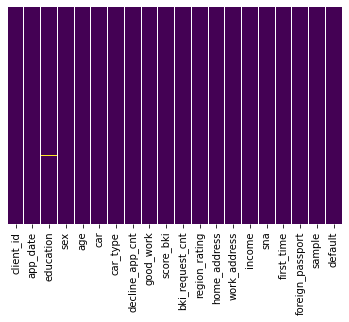

In [68]:
# Проверим данные на наличие пропусков:
missing_data(df)
# Посмотри наглядно на их распределения
sns.heatmap(df.isnull(), yticklabels=False,
            cbar=False, cmap='viridis')

In [69]:
duplicate_data(df)

Дубликатов не обнаружено


0    87.300641
1    12.699359
Name: default, dtype: float64

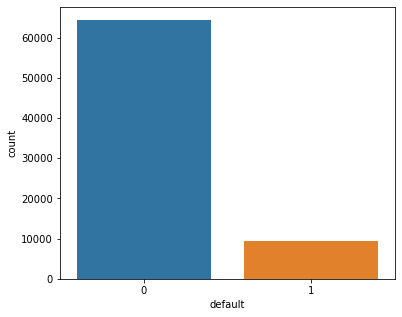

In [70]:
# Посмотрим на распределение значений целевого признака:
fig = plt.subplots(figsize=(6, 5)) 
display(df.query('sample == 1')['default'].value_counts(normalize=True)*100)
sns.countplot(x=df.query('sample == 1')['default']); # для точности картины рассматриваем тролько тренировочные данные

### Сформулируем выводы:

- в данных представлено 19 признаков (20-й sample мы не считаем, так как он был искусствено создан для удобства разделения обучающей и тестовой выборки)
- в объединенном датасете 110148 наблюдений
- дубликаты отсутствуют
- имеются пропуски только в 1 признаке - education: 478 , 0.43%
- Распределение целевой переменной - 87.3% / 12.7%. Пропорция ~ 1:7 (предел нормы 1:10), присутствует достаточно большая несбалансированность классов с которой в дальнейшем можно поработать и применить методы oversampling и undersampling (выбрать наиболее подходящий).

# Рассмотрим признаки

In [71]:
# Для упрощения дальнейшей работы создадим типовые списки признаков
df_cols = list(df)
num_cols = ['client_id', 'app_date', 'age','bki_request_cnt', 'score_bki', 'income', 'decline_app_cnt'] # 7 признаков
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport'] # 5 признаков
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time'] # 6 признаков

## Работа с числовыми признаками

In [72]:
# Как мы опредилили ранее, пропусков и дубликатов в числовых признаках нет.
df[num_cols].head()

,client_id,app_date,age,bki_request_cnt,score_bki,income,decline_app_cnt
0,74835,22MAR2014,29,3,-2.271884,50000,0
1,17527,24JAN2014,39,2,-1.504999,5000,5
2,75683,23MAR2014,50,1,-1.691339,30000,0
3,26883,03FEB2014,56,1,-2.374182,17000,0
4,28862,04FEB2014,38,0,-2.487502,120000,0


In [73]:
# Первичный осмотр дает предположение, что client_id присвоен по порядку в соответствии с датой обращения.
# проверим гипотезу
df['client_id'].nunique() == df.shape[0]

True

#### Вывод:
- все client_id уникальны и явно не пригодятся при построении модели

In [74]:
num_cols.remove('client_id')

In [75]:
# рассмотри признак app_date, для этого приведем его в соответствующий вид
df['app_date'] = pd.to_datetime(df['app_date'])

In [76]:
# Посмотрим какой период охватывают наблюдения:
print(f"{df['app_date'].dt.year.unique()}\n{df['app_date'].dt.month_name().unique()}\n{sorted(df['app_date'].dt.day.unique())}")

[2014]
['March' 'January' 'February' 'April']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


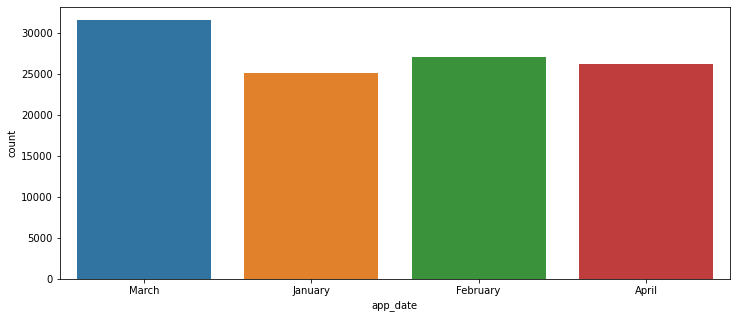

In [77]:
# Посмотрим как распределена дата подачи заявок по месяцам:
fig = plt.subplots(figsize=(12, 5))
sns.countplot(x=df['app_date'].dt.month_name());

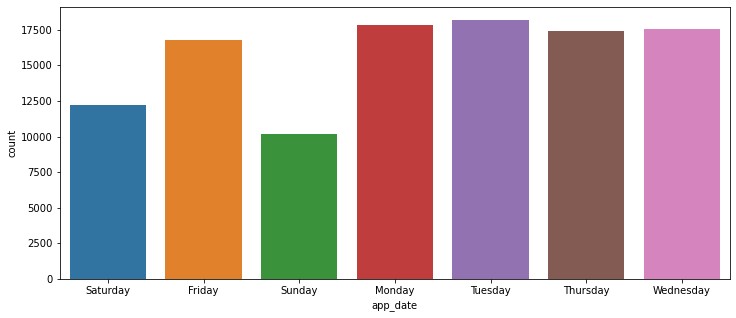

In [78]:
# Посмотрим как распределена дата подачи заявок по дням недели:
fig = plt.subplots(figsize=(12, 5))
sns.countplot(x=df['app_date'].dt.day_name());

In [79]:
'''На основе признака app_date создадим категориальные признаки, которые отражают день недели и месяц 
в который была подана заявка. И заменим названия на числа.'''
dict_value_days = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
dict_value_months = {'January':1, 'February':2, 'March':3, 'April':4}
df['app_day'] = df['app_date'].dt.day_name().map(dict_value_days)
df['app_month'] = df['app_date'].dt.month_name().map(dict_value_months)

**Резюме**: Признак ***app_date*** - охватывает период подачи заявок с начала января по конец апреля 2014 года. Следует отметить, что количество поданных заявок в марте значительно больше. В будние дни приблизительно равны, однако заметно явное снижение их количества в выходные. На основе признака ***app_date*** были созданы два категориальных признака ***app_day*** и ***app_month***, которые отражают месяц и день подачи заявки. Признак ***app_date*** далее не пригодится.

In [80]:
# Обновим списки признаков:
num_cols.remove('app_date')
cat_cols.extend(['app_day', 'app_month'])

Наименование признака: age
25-й перцентиль: 30.0 75-й перцентиль: 48.0, IQR: 18.0,  Границы выбросов: [3.0, 75.0].
Выбросов, согласно IQR: 0 | 0.00%
Наименование признака: bki_request_cnt
25-й перцентиль: 0.0 75-й перцентиль: 3.0, IQR: 3.0,  Границы выбросов: [-4.5, 7.5].
Выбросов, согласно IQR: 1755 | 2.38%
Наименование признака: score_bki
25-й перцентиль: -2.259533835 75-й перцентиль: -1.56983126, IQR: 0.6897025750000001,  Границы выбросов: [-3.2940876975, -0.5352773974999998].
Выбросов, согласно IQR: 351 | 0.48%
Наименование признака: income
25-й перцентиль: 20000.0 75-й перцентиль: 48000.0, IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].
Выбросов, согласно IQR: 4695 | 6.36%
Наименование признака: decline_app_cnt
25-й перцентиль: 0.0 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].
Выбросов, согласно IQR: 12585 | 17.05%


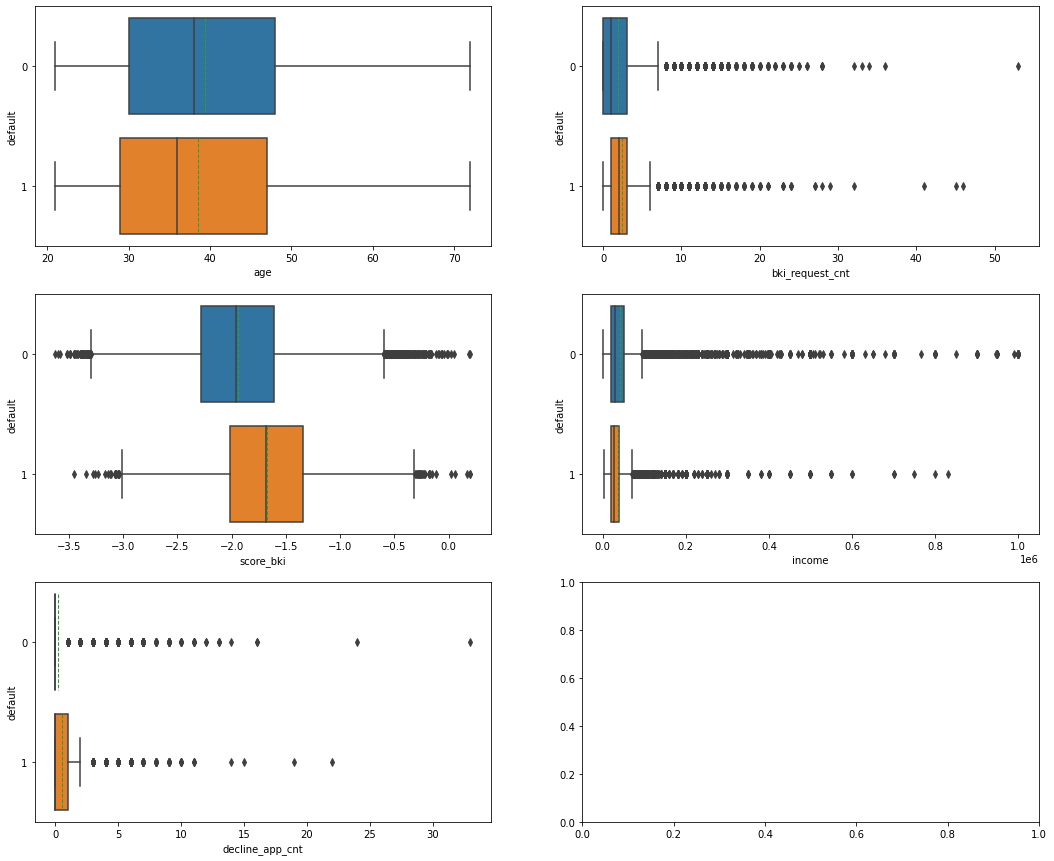

In [81]:
# Проведем анализ для выявления выбросов числовых признаков, для наглядности постоим boxplot:
fig, axes = plt.subplots(3, 2, figsize=(18,15))
for i, column in enumerate(num_cols):
    sns.boxplot(x=df.query('sample == 1')[column],
                y=df.query('sample == 1')['default'],
                ax=axes.flat[i],
                showmeans=True,
                meanline=True,
                orient='h')
    IQR_outlier(df.query('sample == 1'), column)
    print('=='*20)

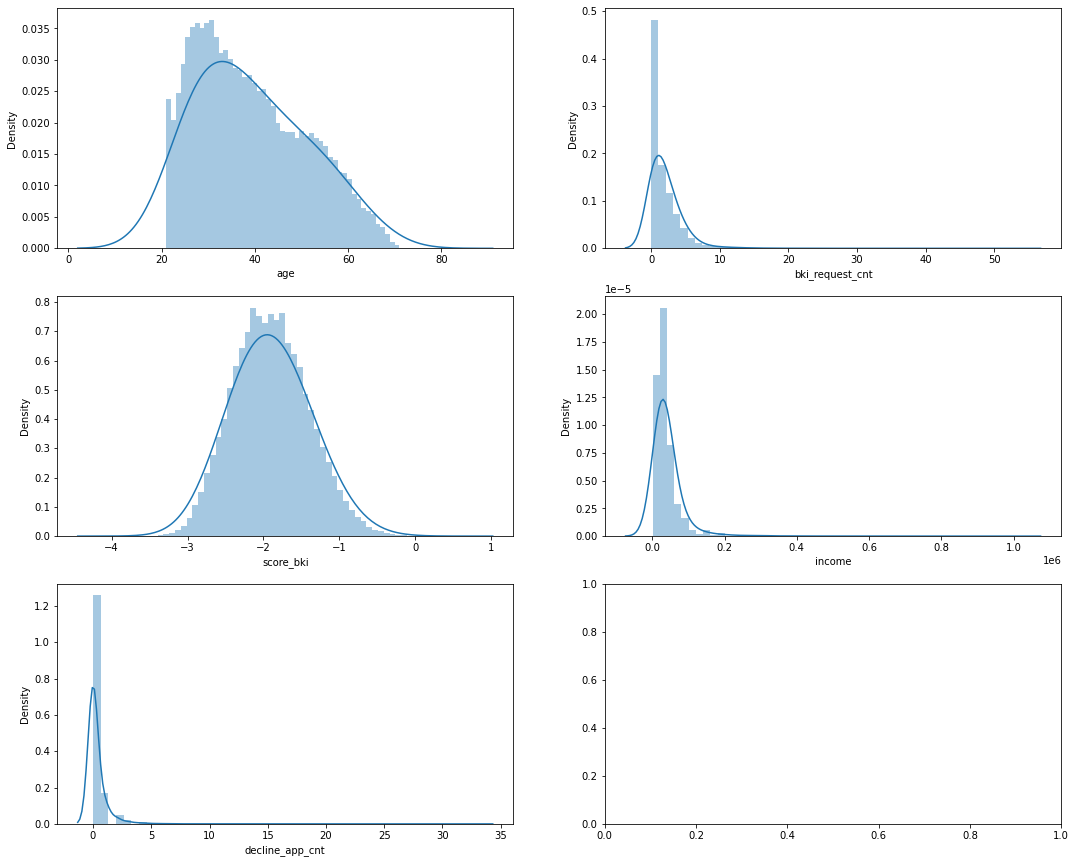

In [82]:
# Посмотрим на распределение признаков
fig, axes = plt.subplots(3, 2, figsize=(18,15))
for i,col in enumerate(num_cols):
    sns.distplot(df[col], ax=axes.flat[i], bins=50, kde_kws={'bw': 0.55})

In [83]:
# Посмотрим статистику по числовым признакам:
df.query('sample == 1')[num_cols].describe()

,age,bki_request_cnt,score_bki,income,decline_app_cnt
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,39.280641,2.000339,-1.904724,41099.775417,0.275749
std,11.520378,2.252073,0.498231,46166.322400,0.804272
min,21.000000,0.000000,-3.624586,1000.000000,0.000000
25%,30.000000,0.000000,-2.259534,20000.000000,0.000000
50%,37.000000,1.000000,-1.920823,30000.000000,0.000000
75%,48.000000,3.000000,-1.569831,48000.000000,0.000000
max,72.000000,53.000000,0.199773,1000000.000000,33.000000


### Промежуточные выводы:

- признак ***age*** - возраст. Минимальное значение - 21, максимальное - 72. Средний возраст заемщика - 39, медианный - 37. Есть небольшое смещение, но не сильное. Выбросы в данном признаке не обнаружены.
- признак ***bki_request_cnt***. Значения от 0 до 53. Самое часто встречающееся значение 0 занимает 26,2% всех наблюдений. Распределение имеет тяжелый правый хвост, поэтому есть смысл логарифмирования данного признака. Также присутствуют выбросы в количестве 2636, однако удалять данные о людях которые обращались в БКИ больше 2 раз не вижу необходимости.
- признак ***score_bki***. Имеет нормальное распределение, однако странно, что имеются отрицательные значения, так как обычно скоринговый балл положительный. Распределение нормальное, предварительно есть выбросы в количестве 518. Но с учетом странной природы данного признака удалять выбросы, пока, не буду.
- признак ***income***. Имеет смещенное распределение, очень большой разброс значений - от 1000 до 1000000. Такой доход имеет место быть, хотя анализ показывает большое кол-во выбросов. Здесь можно попробовать ввести категориальный признак, посмотрев на распределение и зависимости признака с целевой переменной, присвоив значениям дохода категории - низкий доход, средний, выше среднего и т.д.
- признак ***decline_app_cnt***. 83% наблюдений имеют значение 0. Распределение смещенное. Максимальное значение - 33. Как мы видим, 98% распределения лежит в значениях 0, 1, 2, 3. Выбросов, согласно IQR: 12585, считаю важным оставить значения "выбросов" без обработки. Думаю имеет смысл создать признак бинарных значений (есть ли отказаные заявки).

In [84]:
# Создадим бинарный признак отказа по заявкам:
# Если отказы были, присваиваю 1, если нет - 0.
rejected_app = []
for x in df['decline_app_cnt']:
    if x >= 1:
        x = 1
    else:
        x = 0
    rejected_app.append(x)
# Добавим получившейся список в наш DataFrame
df['rejected_app'] = pd.DataFrame(rejected_app)
# добавим признак в список
bin_cols.append('rejected_app')

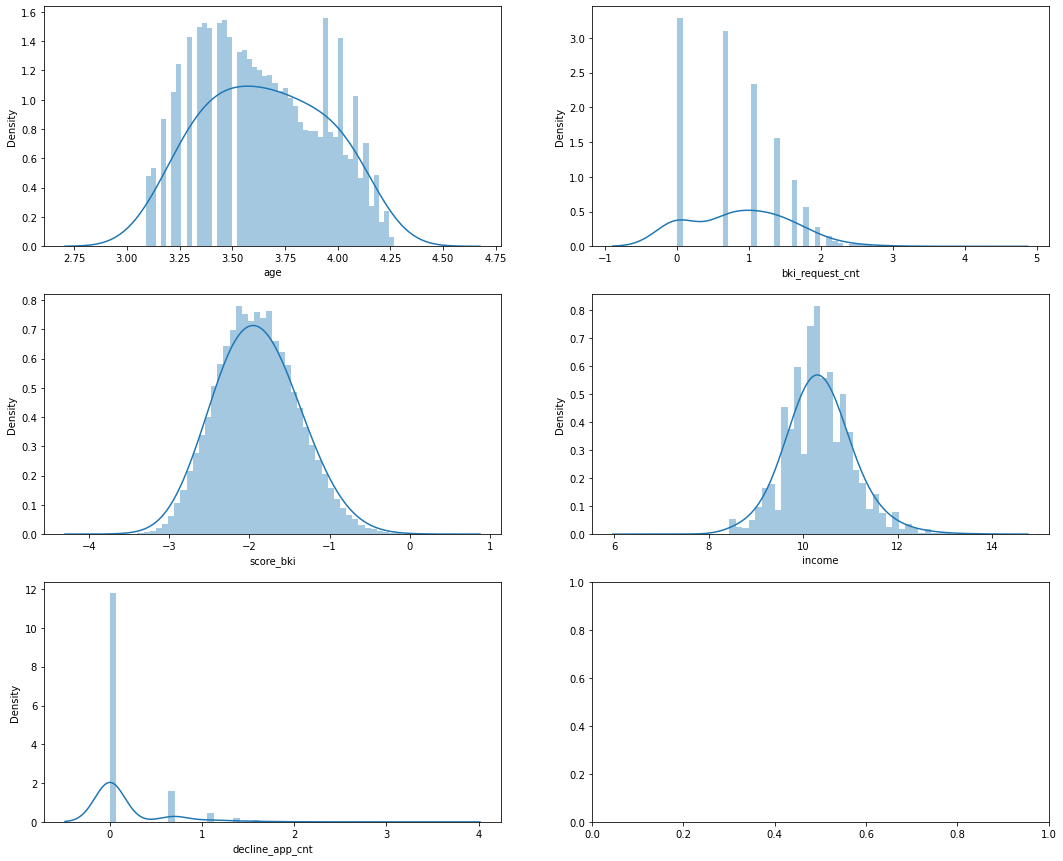

In [85]:
# Прологарифмируем признаки у которых смещенны распределения:
log_features = ['age', 'bki_request_cnt', 'income', 'decline_app_cnt']
for column in log_features:
    df[column] = get_log(df, column)
# Посмотрим на распределения числовых признаков после преобразований:
fig, axes = plt.subplots(3, 2, figsize=(18,15))
for i,col in enumerate(num_cols):
    sns.distplot(df[col], ax=axes.flat[i], bins=50, kde_kws={'bw': 0.45})

### Корреляционный анализ

<AxesSubplot:>

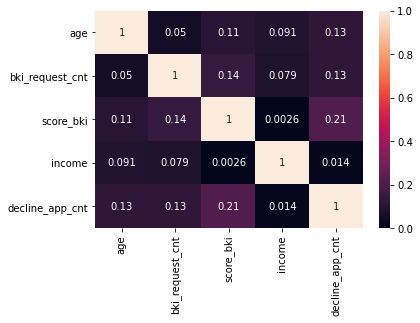

In [86]:
sns.heatmap(df[num_cols].corr().abs(), annot = True, vmin=0, vmax=1)

### Оценка значимости признаков

<AxesSubplot:>

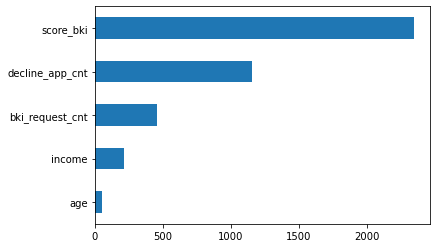

In [87]:
# Определим значимость числовых признаков с помощью функции mutual_info_classif:
imp_num = pd.Series(f_classif(df.query('sample == 1')[num_cols], df.query('sample == 1')['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

**Резюме**: Максимальное значение коэффициента корреляции составляет 0,19 между признаками ***score_bki/decline_app_cnt***. Это говорит о достаточно слабой корреляции между признаками. Оценка значимости числовых признаков показывает, что все признаки в той или иной степени влияют на целевой. Самым значимым из чиловых признаков является ***score_bki***.

## Категориальные признаки

In [88]:
df[cat_cols].head()

,education,region_rating,home_address,work_address,sna,first_time,app_day,app_month
0,GRD,50,1,2,1,4,6,3
1,SCH,50,1,2,4,3,5,1
2,UGR,50,1,2,1,3,7,3
3,SCH,40,1,2,1,3,1,2
4,GRD,80,2,3,1,3,2,2


<AxesSubplot:xlabel='education', ylabel='count'>

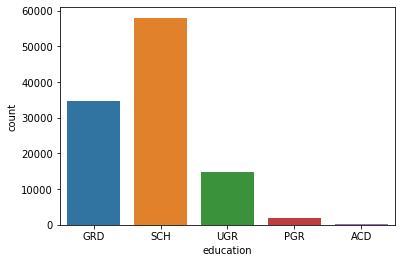

In [89]:
# Ранее мы определили что признак образования имеет пропуски, обработаем их
# посмотрим на распределение клиентов по образованию
sns.countplot(x=df['education'])

In [90]:
#Заполним пропуски самым частым значением 'SCH'
df['education'].fillna('SCH', inplace=True)

In [91]:
# Заменим буквенные обозначения на числовые:
dict_value_education = {'SCH':0,'GRD':1,'UGR':2,'PGR':3,'ACD':4}
df['education'] = df['education'].map(dict_value_education).astype('int8')

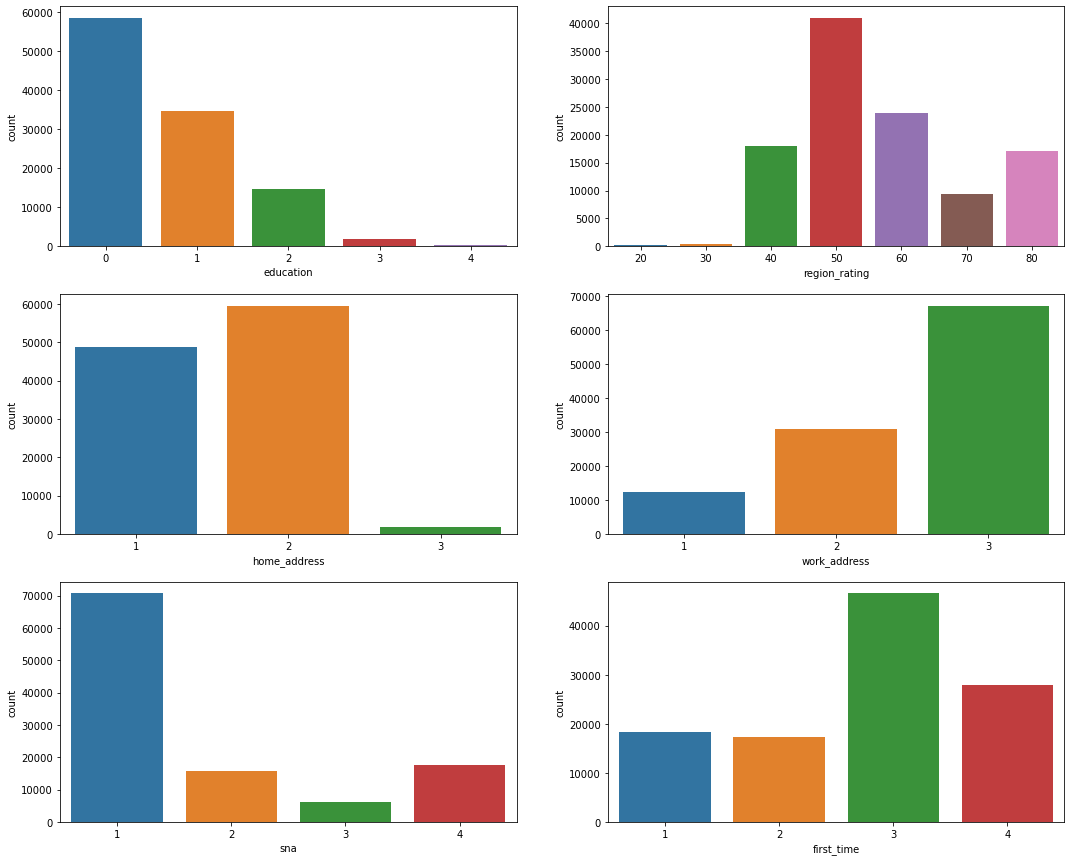

In [92]:
# Посмотрим на распределения категориальных признаков:
fig, axes = plt.subplots(3, 2, figsize=(18,15))
for i,col in enumerate(cat_cols[:-2]):
        sns.countplot(df[col], ax=axes.flat[i]);

In [93]:
# Сократим значения признака region_rating до единиц:
df['region_rating'] = df['region_rating'].map(lambda x: 0.1 * x).astype('int8')

<AxesSubplot:>

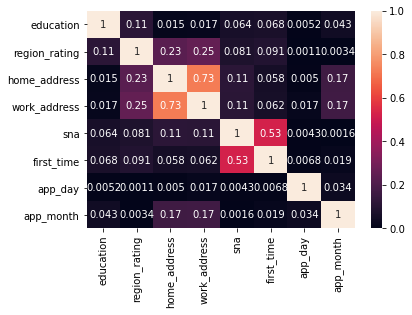

In [94]:
# Проведем корреляционный анализ категоральных признаков
sns.heatmap(df[cat_cols].corr().abs(), annot = True, vmin=0, vmax=1)

Признаки ***home_address*** и ***work_address*** имеют высокую корреляцию между собой (0.73). Удаление данных признаков привело к ухудшению результатов, решением стало их объединение,с применением метода декомпозиции.

In [95]:
# Выберем нужные колонки:
address_cols = df[['work_address', 'home_address']].values
# Из двух признаков сделаем один путем усечения ненужной информации:
pca = PCA(n_components=1)
df['address'] = pca.fit_transform(address_cols)
# Обновим список категориальных признаков:
cat_cols.remove('home_address')
cat_cols.remove('work_address')
cat_cols.append('address')

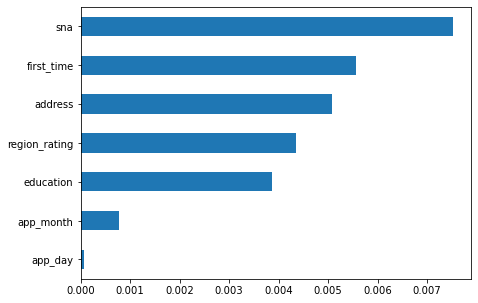

In [96]:
# определим значимость категориальных признаков с помощью функции mutual_info_classif
fig = plt.subplots(figsize=(7, 5))
imp_cat = pd.Series(mutual_info_classif(df.query('sample == 1')[cat_cols], df.query('sample == 1')['default'],
                                        discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh');

**Резюме:**

признак ***education*** имеет 0.43% пропусков. Самое часто встречающееся значние SCH (школа), принял решения заполнить им пропуски. Признак имеет 5 уникальных значений. SCH - школьное образование, UGR - бакалавриат, GRD - магистратура, PGR - дополнительные программы после бакалавриата и ACD - научные степени (кандидат, доктор).
признак region_rating. Содержит 7 числовых значений, но является категориальным. Принял решения сократить данный признак на 10.
признак home_address/work_address. Имеют по три категории. 
признак sna / first_time. Имеют по 4 категории.
признак ***app_month*** имеет большую значимость чем ***app_day***.

## Бинарные признаки

In [98]:
df[bin_cols].head()

,sex,car,car_type,good_work,foreign_passport,rejected_app
0,M,Y,Y,0,N,0
1,F,N,N,0,N,1
2,M,Y,Y,0,Y,0
3,M,N,N,0,N,0
4,F,N,N,0,N,0


In [99]:
# проведем Label Encoding бинарных признаков
le = LabelEncoder()
for column in bin_cols:
    df[column] = le.fit_transform(df[column])
    print(dict(enumerate(le.classes_)))

df[bin_cols].head()

{0: 'F', 1: 'M'}
{0: 'N', 1: 'Y'}
{0: 'N', 1: 'Y'}
{0: 0, 1: 1}
{0: 'N', 1: 'Y'}
{0: 0, 1: 1}


,sex,car,car_type,good_work,foreign_passport,rejected_app
0,1,1,1,0,0,0
1,0,0,0,0,0,1
2,1,1,1,0,1,0
3,1,0,0,0,0,0
4,0,0,0,0,0,0


<AxesSubplot:>

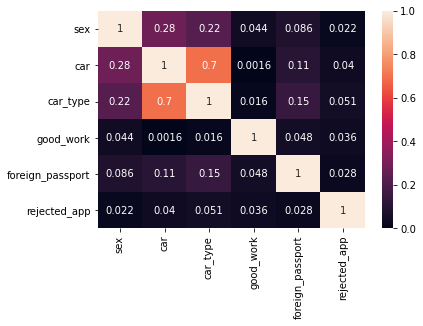

In [100]:
# Проведем корреляционный анализ бинарных признаков
sns.heatmap(df[bin_cols].corr().abs(), annot = True, vmin=0, vmax=1)

Признаки ***car*** и ***car_type*** имеют высокую корреляцию между собой (0.70). Удаление из дальнейшего рассмотрения признак car, как менее значимого, привел к улучшению модели. Однако наилучшим результатом стало объединение этих признаков,с применением метода декомпозиции и удалением признака ***car_type***.

In [101]:
# Выберем нужные колонки:
car_columns = df[['car', 'car_type']].values
# Из двух признаков сделаем один путем усечения ненужной информации:
pca = PCA(n_components=1)
df['car'] = pca.fit_transform(car_columns)

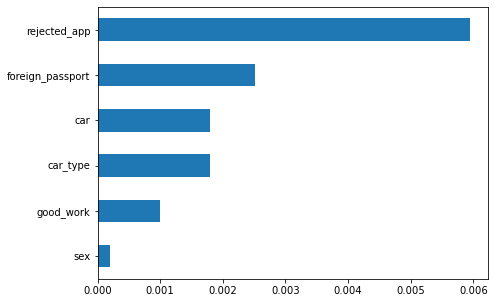

In [102]:
# Определим значимость бинарных признаков с помощью функции mutual_info_classif:
fig = plt.subplots(figsize=(7, 5))
imp_bin = pd.Series(mutual_info_classif(df.query('sample == 1')[bin_cols], df.query('sample == 1')['default'],
                                        discrete_features=True), index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh');

In [103]:
# Обновим список бинарных признаков:
bin_cols.remove('car_type')

**Резюме:**

признак ***sex*** - пол. Бинарный признак, имеет два значения. В выборке предсатвлено больше женщин, чем мужчин, однако разница небольшая.
признак ***car, car_type*** - наличие автомобили, флаг иномарки. Бинарные признаки. Имеют высокую линейную зависимость, принял решение объединить признаки методом декомпозиции.
признак ***good_work***. Бинарный признак, имеет два значения.
признак ***foreign_passport***. Бинарный признак, имеет два значения.

# Подготовка данных к обучению

In [104]:
# Разделим объединенный датасет на тренировочный и тестовый:
train = df.query('sample == 1').drop(['sample'], axis=1)
test = df.query('sample == 0').drop(['sample', 'default'], axis=1)

In [105]:
# Создадим массив числовых признаков и стандартизируем его при помощи StandardScaler:
standart_scaler = StandardScaler()
X_train_num = standart_scaler.fit_transform(train[num_cols])
X_test_num = standart_scaler.fit_transform(test[num_cols])
print(X_train_num.shape, X_test_num.shape)

(73799, 5) (36349, 5)


In [106]:
# Создадим массив категориальных признаков и сделаем OneHotEncoding:
ohe = OneHotEncoder(sparse=False).fit(df[cat_cols])
X_train_cat = ohe.transform(train[cat_cols])
X_test_cat = ohe.transform(test[cat_cols])
print(X_train_cat.shape, X_test_cat.shape)

(73799, 41) (36349, 41)


In [107]:
# Создадим массив бинарных признаков:
X_train_bin = train[bin_cols].values
X_test_bin = test[bin_cols].values
print(X_train_bin.shape, X_test_bin.shape)

(73799, 5) (36349, 5)


In [108]:
# Объединяем в одно признаковое пространство тренировочную выборку: 
X = np.hstack([X_train_num, X_train_cat,  X_train_bin])
y = train['default'].values
print(X.shape, y.shape)

(73799, 51) (73799,)


In [109]:
# Объединяем в одно признаковое пространство тестовую выборку:
X_test = np.hstack([X_test_num, X_test_cat,  X_test_bin])
X_test.shape

(36349, 51)

In [110]:
# Оversampling  ADASYN:
ada = ADASYN(random_state=RANDOM_SEED)
X_ada, y_ada = ada.fit_resample(X, y)
print(X_ada.shape, y_ada.shape)

(127436, 51) (127436,)


Для борьбы с дисбалансом выборки были опробированы методы из библиотеки **imblearn:**

**Undersampling**: ***RandomUnderSampler, NearMiss.***
**Oversampling**: ***RandomOverSampler, SMOTE, ADASYN.***
Наилучшие результаты показал метод ***ADASYN***.

In [111]:
# Разбиваем данные на тренировочные и валидационные:
X_train, X_val, y_train, y_val = train_test_split(X_ada, y_ada, train_size=0.70, random_state=RANDOM_SEED)
print(f'Размер тренировочной выборки: {X_train.shape}\nРазмер валидационной выборки: {X_val.shape}')

Размер тренировочной выборки: (89205, 51)
Размер валидационной выборки: (38231, 51)


# Обучение и оценка качества модели

### Гиперпараметры

In [112]:
train_model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=RANDOM_SEED)

In [113]:
# Зададим ограничения для параметра регуляризации:
C = np.logspace(0, 4, 10)
penalty = ['l1', 'l2']
class_weight = [None, 'balanced']
# Создадим гиперпараметры:
hyperparameters = dict(C=C, penalty=penalty)

In [122]:
# Создаем сетку поиска с использованием 5-кратной перекрестной проверки:
clf = GridSearchCV(train_model, hyperparameters, cv=5, scoring='f1_weighted')
best_train_model = clf.fit(X_train, y_train).best_estimator_
# Посмотрим на лучшие гиперпараметры:
best_parameters = best_train_model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

	C: 21.544346900318832
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 1000
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l1'
	random_state: 41
	solver: 'liblinear'
	tol: 0.0001
	verbose: 0
	warm_start: False


In [123]:
train_model = LogisticRegression(solver='liblinear', penalty='l1', C=21.5,
                                class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED)
train_model.fit(X_train, y_train)
# best_parameters['penalty'], best_parameters['C']

LogisticRegression(C=21.5, class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=41, solver='liblinear')

In [124]:
y_pred = train_model.predict(X_val)
y_pred_proba = train_model.predict_proba(X_val)

In [125]:
# Оценка качества:
print('balanced_accuracy_score: %0.3f' % balanced_accuracy_score(y_val, y_pred))
print('cohen_kappa_score: %0.3f' % cohen_kappa_score(y_val, y_pred))
print('precision_score: %0.3f' % precision_score(y_val, y_pred))
print('recall_score: %0.3f' % recall_score(y_val, y_pred))
print('f1_score: %0.3f' % f1_score(y_val, y_pred))
print('roc_auc_score: %0.5f' % roc_auc_score(y_val, y_pred_proba[:, 1]))
fpr, tpr, threshold = roc_curve(y_val, y_pred_proba[:, 1])

balanced_accuracy_score: 0.678
cohen_kappa_score: 0.356
precision_score: 0.670
recall_score: 0.688
f1_score: 0.679
roc_auc_score: 0.74225


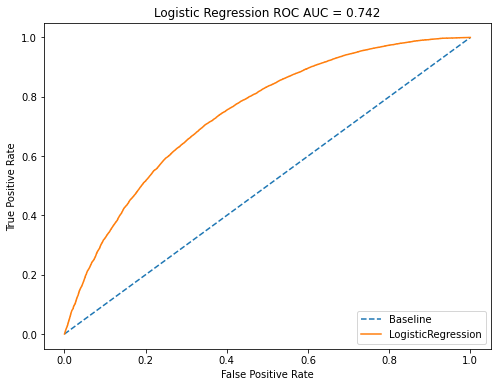

In [126]:
# Визаулизация ROC AUC:
fig = plt.subplots(figsize=(8, 6))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'LogisticRegression')
plt.title(f'Logistic Regression ROC AUC = {roc_auc_score(y_val, y_pred_proba[:, 1]):0.3f}')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

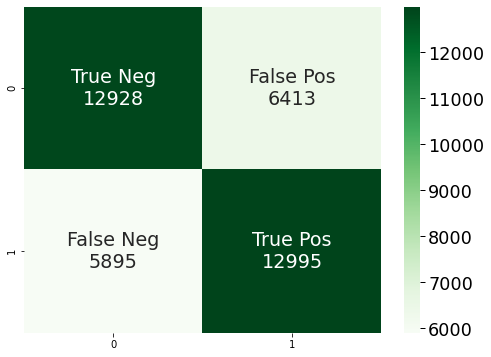

In [127]:
# Confusion matrix:
fig = plt.subplots(figsize=(8, 6))
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_val, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_val, y_pred), annot=labels, fmt='', cmap='Greens');


In [128]:
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).flatten()
print(f'Предсказано, что {fp} или {round((fp/(fp+tn))*100, 2)}% по факту вернувших кредит клиентов не вернут его.')
print(f'Предсказано, что {fn} или {round((1-recall_score(y_val, y_pred))*100, 2)}% по факту не вернувших кредит клиентов вернут его.')

Предсказано, что 6413 или 33.16% по факту вернувших кредит клиентов не вернут его.
Предсказано, что 5895 или 31.21% по факту не вернувших кредит клиентов вернут его.


# Submission

In [129]:
test['default'] = train_model.predict_proba(X_test)[:, 1]

In [130]:
submission = test[['client_id', 'default']]
display(submission.sample(10))

,client_id,default
9576,108335,0.540167
33754,6351,0.229551
31438,55560,0.531088
978,55949,0.287949
7594,97265,0.466563
35990,51466,0.595148
8441,73034,0.257496
31729,3968,0.511274
7552,99237,0.115517
31635,83184,0.567311


In [131]:
submission.to_csv('submission.csv', index=False)